Part 1 
---------------

In [1]:
## Import packages we will use 
import json
import pprint 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections 
import tensorflow as tf
from sklearn.manifold import TSNE

In [2]:
np.random.seed(11262017)

In [3]:
## Read the data, one line (= one json) at a time 
file = open("products-sample.json")

data = []

for line in file:
    data.append(json.loads(line))

In [4]:
## Explore the data 
print("This is how one json looks like: \n")
pprint.pprint(data[9], depth=1)
## pprint.pprint(data[0]["variant_data"][0]["params"], depth=4)

print("\n\nThere are", len(data), "jsons in the data")

This is how one json looks like: 

{'brand': {...},
 'brief_plain': {...},
 'date': '2017-11-15T08:40:00.822Z',
 'product_id': '1043735',
 'product_type': {...},
 'title_full': {...},
 'user_id': 'f193a03cabf477202d7c342a8d199460',
 'variant_data': [...],
 'variant_id': '1043735004'}


There are 106 jsons in the data


Part 2
--------------

Now we will create list "groups" which will have structure

[ [ids of products of customer 1], 
  [ids of products of customer 2],
  .
  .
  .
  [ids of products of customer n] ]

In [5]:
## Create dataframe with columns "user_id", "product_id"
user_product = pd.DataFrame([{"user": j["user_id"], "product" : j["product_id"]} for j in data])

In [6]:
## Group "user_product" by user, select groups with at least 2 elements 
grouping = user_product.groupby(by=["user"])
group_series = grouping.product.apply(list)
group_counts = list(grouping.count().iloc[:,0])
at_least_2 = [x>1 for x in group_counts]
groups = list(group_series[at_least_2])
group_counts = [group_counts[i] for i in range(len(at_least_2)) if at_least_2[i]] 

In [7]:
## Explore the groups (each representing a customer who viewed details of at least 2 products)
## Notice that sometimes there are two identical products in one group (user viewed it twice)
print("These are the groups: \n")
pprint.pprint(groups)

print("\n\nThere are", len(groups), "groups")

These are the groups: 

[['935880', '935804'],
 ['1079941', '1079941'],
 ['1036818', '1067651'],
 ['1074485', '1070850'],
 ['1012091', '1077488'],
 ['1036823', '1063697', '1036823'],
 ['937412', '1079350'],
 ['1073114', '1069170', '996046', '1012185', '996046'],
 ['1076284', '1076361'],
 ['1085963', '1085963'],
 ['935880', '935880'],
 ['1091285', '1091285'],
 ['847827', '847829'],
 ['1039048', '1067061']]


There are 14 groups


Part 3
-----------------

The rest of this notebook is heavily based on https://www.tensorflow.org/tutorials/word2vec

The code is not very clean

For each product (that is for each word in the terminology of word2vec) we learn its vector representation aka embedding

This vector representation is designed in such a way that similar products (in the sense that they appear often together in one customers list) will have similar vectors (measured in standard eucleidean distance) 

In [8]:
n_words = 50000
words = [x for y in groups for x in y]
counts = collections.Counter(words).most_common(n_words - 1)
dictionary = dict()
for word, _ in counts:
        dictionary[word] = len(dictionary)
reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [9]:
nr_contexts = len(group_counts)

In [10]:
def create_batch(batch_size = 8):
    """ Creates batch of radnomly selected word indices and their context word indices
    
        Arguments:
        batch_size -- len of word indices and context word indices 
        
        Return: 
        batch -- word indices
        labels -- context word indices 
    """
    batch = []
    labels = []
    ## select randomly word + word from context 
    ## first select randomly contexts (we select context with probability proportional to its number of words)
    contexts_sample = np.random.multinomial(n = batch_size, pvals = group_counts/sum(group_counts))
    for i in range(nr_contexts):
        for j in range(contexts_sample[i]):
            group_i = groups[i]
            ii = np.random.choice(len(group_i), 2, replace=True)
            batch.append(dictionary[group_i[ii[0]]])
            labels.append(dictionary[group_i[ii[1]]])
    return np.array(batch), np.array(labels).reshape((-1,1))
        

In [11]:
## Size of training batch
batch_size = 16

## Length of word embedding vector
embedding_size = 16

## Number of distinct words
vocabulary_size = len(counts)

## Number of negative examples, see nonnegative sampling 
num_sampled = 16

In [12]:
## Definition of tensorflow model
## this is basically copied source code from the link above

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                           biases=nce_biases,
                           labels=train_labels,
                           inputs=embed,
                           num_sampled=num_sampled,
                           num_classes=vocabulary_size))

optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

init = tf.global_variables_initializer()

In [13]:
sess = tf.Session()
sess.run(init)

In [14]:
## Learn the embeddings
for i in range(30000): 
    batch, labels = create_batch(batch_size)
    sess.run(optimizer, {train_inputs : batch, train_labels : labels})

In [15]:
## Embeddings matrix (each row is embedding of one word) 
E = sess.run(embeddings)

In [16]:
E.shape

(25, 16)

We can display the embeddings using a technique called t-SNE, this basicaly maps the 16 dimensional vectors to 2 dimensional vectors in a way that vectors that had small eucleidean distance in the 16 dimensions will have small eucleidean distance in the 2 dimensions

In [17]:
E_embedded = TSNE(n_components=2).fit_transform(E)
E_embedded.shape

(25, 2)

In [18]:
customer_7 = np.repeat("blue", E.shape[0])
customer_7[[i for k,i in dictionary.items() if k in groups[7]]] = "red"
customer_7

array(['blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue',
       'blue', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'blue',
       'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue',
       'red'], 
      dtype='<U4')

Now we can plot TSNE of the embeddings, notice that for example items of one customer are close together 

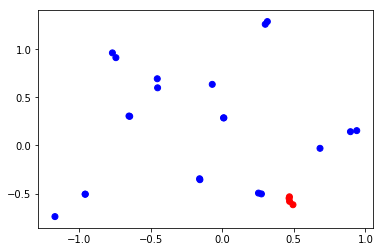

In [19]:
plt.scatter(E[:,0], E[:,1], c=customer_7)
plt.show()